In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load Data
fake_news = pd.read_csv('data/fake.csv')  
real_news = pd.read_csv('data/real.csv')  

fake_news['labels'] = 1
real_news['labels'] = 0

data = pd.concat([fake_news[['title', 'labels', 'news_url']], real_news[['title', 'labels', 'news_url']]], ignore_index=True)
data.dropna(subset=['title'], inplace=True)

In [3]:
# Extract URL features
import tldextract
def extract_url_features(url):
    if isinstance(url, float):
        url = str(url)
    ext = tldextract.extract(url)
    return {
        'domain': ext.domain,
        'subdomain': ext.subdomain,
        'url_length': len(url),
        'has_query': 1 if '?' in url else 0,
        'has_hyphens': 1 if '-' in url else 0,
        'has_numbers': 1 if any(c.isdigit() for c in url) else 0,
    }

url_features = data['news_url'].apply(extract_url_features)
url_features_df = pd.DataFrame(url_features.tolist())

# Encode and normalize URL features
url_features_encoded = pd.get_dummies(url_features_df, columns=['domain', 'subdomain'])
scaler = StandardScaler()
url_features_encoded = pd.DataFrame(scaler.fit_transform(url_features_encoded), columns=url_features_encoded.columns)

In [4]:
# Vectorize Titles
vectorizer = CountVectorizer(max_features=5000)
title_features_vectorized = vectorizer.fit_transform(data['title']).toarray()

# Align Data
min_length = min(len(title_features_vectorized), len(url_features_encoded))
title_features_vectorized = title_features_vectorized[:min_length]
url_features_encoded = url_features_encoded.iloc[:min_length]
data = data.iloc[:min_length]

# Apply SMOTE
combined_features = np.hstack([title_features_vectorized, url_features_encoded])
smote = SMOTE(random_state=42)
combined_features_resampled, labels_resampled = smote.fit_resample(combined_features, data['labels'])

# Split Data
train_features, test_features, train_labels, test_labels = train_test_split(combined_features_resampled, labels_resampled, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels.values, dtype=torch.long)

C:\Users\jun_k\anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\jun_k\anaconda3\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [5]:
# Create PyTorch Dataset
class FakeNewsDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Data Loaders
batch_size = 16
train_dataset = FakeNewsDataset(train_features_tensor, train_labels_tensor)
test_dataset = FakeNewsDataset(test_features_tensor, test_labels_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# LSTM Model
class LSTMFakeNewsClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(LSTMFakeNewsClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x.unsqueeze(1))  # Reshape to (batch, seq_len, input_size)
        out = self.fc(out[:, -1, :])  # Take last time step's output
        return out

# Model Initialization
input_dim = train_features.shape[1]
hidden_dim = 128
num_layers = 2
num_classes = 2

model = LSTMFakeNewsClassifier(input_dim, hidden_dim, num_layers, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LSTMFakeNewsClassifier(
  (lstm): LSTM(7475, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [6]:
# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_features, batch_labels in tqdm(train_dataloader):
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader)}")

100%|██████████████████████████████████████████████████████████████████████████████| 1745/1745 [01:09<00:00, 24.94it/s]


Epoch [1/5], Loss: 0.3755675682416426


100%|██████████████████████████████████████████████████████████████████████████████| 1745/1745 [01:11<00:00, 24.25it/s]


Epoch [2/5], Loss: 0.1937399354264311


100%|██████████████████████████████████████████████████████████████████████████████| 1745/1745 [01:11<00:00, 24.41it/s]


Epoch [3/5], Loss: 0.11586091907175904


100%|██████████████████████████████████████████████████████████████████████████████| 1745/1745 [01:12<00:00, 24.22it/s]


Epoch [4/5], Loss: 0.07430642451887502


100%|██████████████████████████████████████████████████████████████████████████████| 1745/1745 [01:13<00:00, 23.76it/s]

Epoch [5/5], Loss: 0.054424185010450786


Model saved as fake_news_lstm.pth


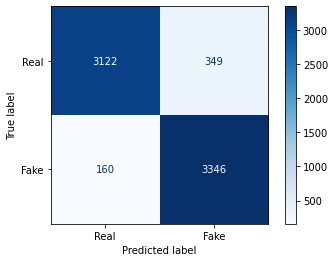

Accuracy: 0.9270460083130285
              precision    recall  f1-score   support

        Real       0.95      0.90      0.92      3471
        Fake       0.91      0.95      0.93      3506

    accuracy                           0.93      6977
   macro avg       0.93      0.93      0.93      6977
weighted avg       0.93      0.93      0.93      6977



In [7]:
# Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_features, batch_labels in test_dataloader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

# Save Model
torch.save(model.state_dict(), "fake_news_lstm.pth")
print("Model saved as fake_news_lstm.pth")

# Evaluation Metrics
accuracy = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Real', 'Fake'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

print("Accuracy:", accuracy)
print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))